In [2]:
%pip install numpy pandas matplotlib seaborn scikit-learn catboost xgboost

In [3]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv("/content/Sport car price.csv")

In [5]:
df.head()

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,Porsche,911,2022,3,379,331,4,"101,200"
1,Lamborghini,Huracan,2021,5.2,630,443,2.8,"274,390"
2,Ferrari,488 GTB,2022,3.9,661,561,3,"333,750"
3,Audi,R8,2022,5.2,562,406,3.2,"142,700"
4,McLaren,720S,2021,4,710,568,2.7,"298,000"


In [6]:
def fill_missing(df):
  # Fill missing values for numerical columns with the median
  # Fill missing values for categorical columns with the most common value (mode)
  categorical_columns = ['Car Make', 'Car Model', 'Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)', 'Price (in USD)']
  for column in categorical_columns:
      df[column].fillna(df[column].mode()[0], inplace=True)
  return df

In [7]:
def price_fix(df):
    # Remove commas and convert 'Price (in USD)' to float
    df['Price (in USD)'] = df['Price (in USD)'].str.replace(',', '', regex=True).astype(float)

    return df

In [8]:
df = fill_missing(df)
df = price_fix(df)
df = df.drop_duplicates()

In [9]:
df

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,Porsche,911,2022,3,379,331,4,101200.0
1,Lamborghini,Huracan,2021,5.2,630,443,2.8,274390.0
2,Ferrari,488 GTB,2022,3.9,661,561,3,333750.0
3,Audi,R8,2022,5.2,562,406,3.2,142700.0
4,McLaren,720S,2021,4,710,568,2.7,298000.0
...,...,...,...,...,...,...,...,...
999,Nissan,370Z,2021,3.7,332,270,5.1,30090.0
1002,Koenigsegg,Jesko,2022,5,1280,1106,2.5,3000000.0
1003,Lotus,Evija,2021,Electric Motor,1972,1254,2,2000000.0
1005,Pagani,Huayra,2021,6,764,738,3,2600000.0


In [10]:
def numerize(df):
  # Convert numeric columns to numeric data types
  numeric_columns = ['Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)']

  for col in numeric_columns:
      df[col] = pd.to_numeric(df[col], errors='coerce')  # Coerce errors to NaN for non-numeric values

  # Set a specific value for 'Engine Size (L)' where it equals 'electric'
  df['Engine Size (L)'] = np.where(df['Engine Size (L)'] == 'electric', 3, df['Engine Size (L)'])
  return df
df = numerize(df)


In [11]:
def add_accelerate(df):
  # Define the bin edges and labels for engine size categories
  bins = [0, 2, 4, 6, float('inf')]
  labels = ['Small', 'Medium', 'Large', 'Extra Large']

  # Create the "Engine Displacement Category" column
  df['Engine Displacement Category'] = pd.cut(df['Engine Size (L)'], bins=bins, labels=labels)
  # Define the conditions and corresponding category labels
  conditions = [
      (df['0-60 MPH Time (seconds)'] < 5),
      (df['0-60 MPH Time (seconds)'] >= 5) & (df['0-60 MPH Time (seconds)'] < 7),
      (df['0-60 MPH Time (seconds)'] >= 7)
  ]
  labels = ['Fast', 'Medium', 'Slow']

  # Create the "Acceleration Category" column
  df['Acceleration Category'] = np.select(conditions, labels, default='Unknown')

  return df
df = add_accelerate(df)

In [12]:
display(df)

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD),Engine Displacement Category,Acceleration Category
0,Porsche,911,2022,3.0,379.0,331.0,4.00,101200.0,Medium,Fast
1,Lamborghini,Huracan,2021,5.2,630.0,443.0,2.80,274390.0,Large,Fast
2,Ferrari,488 GTB,2022,3.9,661.0,561.0,3.00,333750.0,Medium,Fast
3,Audi,R8,2022,5.2,562.0,406.0,3.20,142700.0,Large,Fast
4,McLaren,720S,2021,4.0,710.0,568.0,2.70,298000.0,Medium,Fast
...,...,...,...,...,...,...,...,...,...,...
999,Nissan,370Z,2021,3.7,332.0,270.0,5.10,30090.0,Medium,Medium
1002,Koenigsegg,Jesko,2022,5.0,1280.0,1106.0,2.50,3000000.0,Large,Fast
1003,Lotus,Evija,2021,NaN,1972.0,1254.0,2.00,2000000.0,NaN,Fast
1005,Pagani,Huayra,2021,6.0,764.0,738.0,3.00,2600000.0,Large,Fast


In [13]:
def label_encoder(df):
  columns_to_encode = ['Car Make', 'Car Model', "Engine Displacement Category","Acceleration Category"]

  # Initialize the LabelEncoder
  label_encoder = LabelEncoder()

  # Encode each column
  for column in columns_to_encode:
      df[column] = label_encoder.fit_transform(df[column])
  return df
df = label_encoder(df)
df = fill_missing(df)
display(df)

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD),Engine Displacement Category,Acceleration Category
0,28,18,2022,3.0,379.0,331.0,4.00,101200.0,2,0
1,16,98,2021,5.2,630.0,443.0,2.80,274390.0,1,0
2,11,5,2022,3.9,661.0,561.0,3.00,333750.0,2,0
3,5,130,2022,5.2,562.0,406.0,3.20,142700.0,1,0
4,21,15,2021,4.0,710.0,568.0,2.70,298000.0,2,0
...,...,...,...,...,...,...,...,...,...,...
999,24,1,2021,3.7,332.0,270.0,5.10,30090.0,2,1
1002,15,99,2022,5.0,1280.0,1106.0,2.50,3000000.0,1,0
1003,18,76,2021,4.0,1972.0,1254.0,2.00,2000000.0,4,0
1005,25,95,2021,6.0,764.0,738.0,3.00,2600000.0,1,0


In [14]:
def create_preprocessor(X):
  # # Create Column Transformer with 3 types of transformers
  num_features = X.select_dtypes(exclude="object").columns
  cat_features = X.select_dtypes(include="object").columns
  print(num_features)
  from sklearn.preprocessing import OneHotEncoder, StandardScaler
  from sklearn.compose import ColumnTransformer
  from sklearn.impute import SimpleImputer
  from sklearn.pipeline import Pipeline
  numeric_transformer = StandardScaler()
  oh_transformer = OneHotEncoder()

  preprocessor = ColumnTransformer(
      [
          ("OneHotEncoder", oh_transformer, cat_features),
          ("StandardScaler", numeric_transformer, num_features),
      ]
  )
  return preprocessor

In [15]:
X = df.drop(columns = "Price (in USD)")
Y = df["Price (in USD)"]

In [16]:
preprocessor= create_preprocessor(X)

Index(['Car Make', 'Car Model', 'Year', 'Engine Size (L)', 'Horsepower',
       'Torque (lb-ft)', '0-60 MPH Time (seconds)',
       'Engine Displacement Category', 'Acceleration Category'],
      dtype='object')


In [17]:
X = preprocessor.fit_transform(X)

In [18]:
X.shape

(719, 9)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((575, 9), (144, 9))

In [20]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    print('='*35)
    print('\n')
print(f"max of r2:  {max(r2_list)}")

In [22]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,CatBoosting Regressor,0.865692
5,Random Forest Regressor,0.839346
8,AdaBoost Regressor,0.838012
6,XGBRegressor,0.833147
3,K-Neighbors Regressor,0.829283
4,Decision Tree,0.745135
2,Ridge,0.548282
1,Lasso,0.547434
0,Linear Regression,0.547433


In [189]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 54.74


In [23]:
model.fit(X_train, y_train)

AdaBoostRegressor()

In [24]:
y_pred = model.predict(X_test)

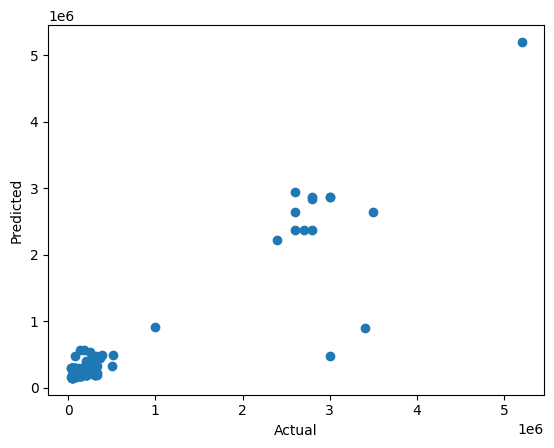

In [25]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

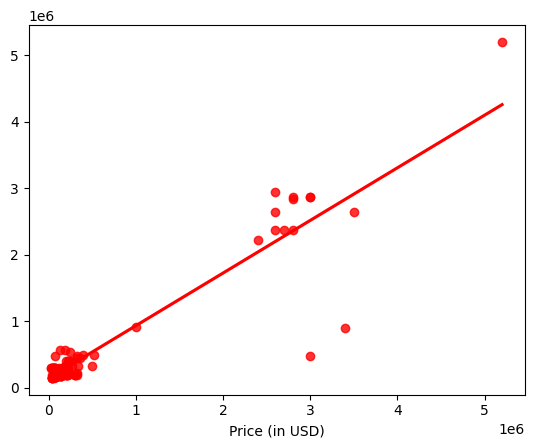

In [26]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

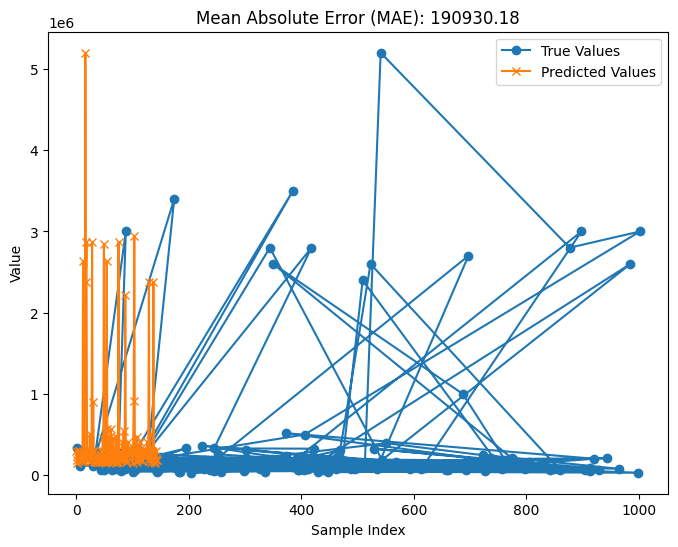

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='True Values', marker='o')
plt.plot(y_pred, label='Predicted Values', marker='x')
plt.title(f'Mean Absolute Error (MAE): {model_test_mae:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [31]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
127,192500.0,297464.552000,-104964.552000
182,42000.0,150340.029197,-108340.029197
39,222000.0,188156.000000,33844.000000
727,180000.0,252746.204819,-72746.204819
228,183000.0,297150.810573,-114150.810573
...,...,...,...
144,44000.0,150340.029197,-106340.029197
340,202500.0,191587.822485,10912.177515
410,81250.0,186804.807018,-105554.807018
41,210000.0,297150.810573,-87150.810573


In [83]:
data = {'Car Make': ['Nissan'],
        'Car Model': ['GTX'],
        'Year': [2022],
        'Engine Size (L)': [3.0],
        'Horsepower': [300],
        'Torque (lb-ft)': [300],
        '0-60 MPH Time (seconds)': [3],
        'Price (in USD)': [None]}  # You can fill in the price later

# Create a new DataFrame with the row data
new_row = pd.DataFrame(data)

In [84]:
new_row

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,Ford,Mustang,2023,5.0,450,410,4,None


In [76]:
def convert_to_price(price):
  return "${:,.2f}".format(price)

In [77]:
new_row = new_row.drop_duplicates()

new_row = numerize(new_row)
new_row = add_accelerate(new_row)
new_row = label_encoder(new_row)

X = new_row.drop(columns = "Price (in USD)")
Y = new_row["Price (in USD)"]

pre = create_preprocessor(X)
X = preprocessor.fit_transform(X)


Index(['Car Make', 'Car Model', 'Year', 'Engine Size (L)', 'Horsepower',
       'Torque (lb-ft)', '0-60 MPH Time (seconds)',
       'Engine Displacement Category', 'Acceleration Category'],
      dtype='object')


In [78]:
test = model.predict(X)

In [79]:
print(test)
test = convert_to_price(test[0])


[293407.42361111]


In [80]:
print(test)

$293,407.42


In [85]:
data = {'test car': new_row["Car Model"],
        'predicted price': test}

# Create a DataFrame
test_df = pd.DataFrame(data)

display(test_df)

,test car,predicted price
0,Mustang,"$293,407.42"
